## Importing Dataset and libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
url = "https://raw.githubusercontent.com/pkk111/Financial-News-Sentiment-Analysis/main/all-data.csv"
df = pd.read_csv(url, delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [3]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

In [4]:
df.shape

(4845, 2)

In [5]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


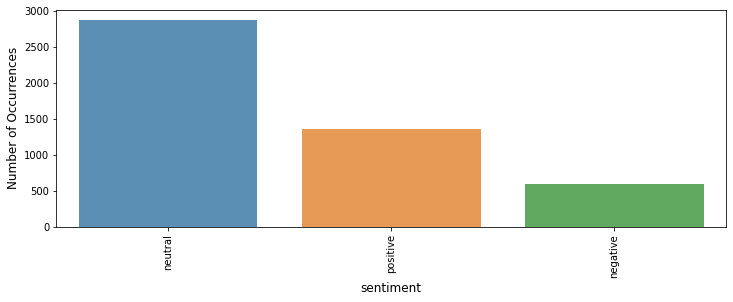

In [6]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [8]:
def print_message(index):
    example = df[df.index == index][['sentiment', 'Message']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

0
Message: Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .


In [9]:
print_message(0)

1
Message: Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .


## Preprocessing

In [10]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

## NEW Preprocessing

In [10]:
from nltk.stem.porter import PorterStemmer

corpus = []

def process_text(message):
  message = re.sub('[^a-zA-Z0-9]', ' ', message)
  message = re.sub(r'http\S+', r'<URL>', message)
  message = message.lower()
  message = message.split()

  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  all_stopwords.append('investment')
  message = [ps.stem(word) for word in message if not word in set(all_stopwords)]
  message = ' '.join(message)
  corpus.append(message)
  return message

df['Message'] = df['Message'].apply(process_text)

## Feature Extraction

In [11]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [13]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', "''", 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

In [14]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 4844/4844 [00:00<00:00, 742560.89it/s]


In [15]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 2496891.80it/s]


CPU times: user 11.5 s, sys: 114 ms, total: 11.7 s
Wall time: 11.9 s


In [16]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [17]:
len(d2v_model.wv.vocab)

11683

In [18]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

In [19]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.854253351688385),
 ('profits', 0.8106234669685364),
 ('income', 0.7724557518959045),
 ('pcmag.com', 0.7400615215301514),
 ('originally', 0.7156936526298523),
 ('koduetra', 0.7154158353805542),
 ('chopra', 0.7090773582458496),
 ('sales', 0.7072404026985168),
 ('68.3', 0.7027767300605774),
 ('satama', 0.6854219436645508)]

In [20]:
d2v_model.wv.most_similar(positive=['invest'], topn=10)

[('kuopio', 0.7305574417114258),
 ('rotterdam', 0.7203152775764465),
 ('ease', 0.7069517374038696),
 ('60-70', 0.6892396211624146),
 ('area', 0.686728835105896),
 ('manturovo', 0.6815937161445618),
 ('1997', 0.6731715202331543),
 ('bovine', 0.6710584163665771),
 ('land', 0.6655532121658325),
 ('adapt', 0.6589417457580566)]

In [21]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9859764575958252),
 ('warmly', 0.886023998260498),
 ("'m", 0.8599976897239685),
 ('my', 0.8526664972305298),
 ('forward', 0.8405531048774719),
 ('comfortably', 0.8293263912200928),
 ('rop', 0.8242896795272827),
 ('gather', 0.8234997987747192),
 ('macro-economic', 0.822793185710907),
 ('paycheck', 0.8224278092384338)]

In [22]:
print(embedding_matrix.shape)

(11684, 20)


In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in d2v_model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [24]:
# tsne_plot(d2v_model)

## Model Building

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            233680    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 248,033
Trainable params: 248,033
Non-trainable params: 0
_________________________________________________________________


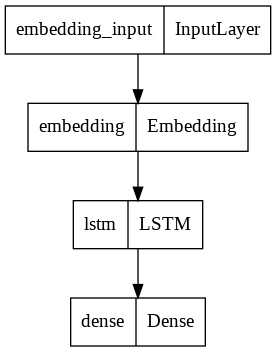

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

## Testing and Training

In [27]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [28]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 5s - loss: 0.5502 - acc: 0.6003 - 5s/epoch - 42ms/step
Epoch 2/50
129/129 - 3s - loss: 0.4134 - acc: 0.7050 - 3s/epoch - 26ms/step
Epoch 3/50
129/129 - 3s - loss: 0.3011 - acc: 0.7919 - 3s/epoch - 26ms/step
Epoch 4/50
129/129 - 3s - loss: 0.2409 - acc: 0.8322 - 3s/epoch - 26ms/step
Epoch 5/50
129/129 - 3s - loss: 0.2035 - acc: 0.8526 - 3s/epoch - 25ms/step
Epoch 6/50
129/129 - 3s - loss: 0.1523 - acc: 0.9068 - 3s/epoch - 25ms/step
Epoch 7/50
129/129 - 3s - loss: 0.0987 - acc: 0.9536 - 3s/epoch - 26ms/step
Epoch 8/50
129/129 - 3s - loss: 0.0659 - acc: 0.9718 - 3s/epoch - 26ms/step
Epoch 9/50
129/129 - 3s - loss: 0.0454 - acc: 0.9813 - 3s/epoch - 26ms/step
Epoch 10/50
129/129 - 3s - loss: 0.0416 - acc: 0.9820 - 3s/epoch - 26ms/step
Epoch 11/50
129/129 - 3s - loss: 0.0355 - acc: 0.9854 - 3s/epoch - 26ms/step
Epoch 12/50
129/129 - 3s - loss: 0.0282 - acc: 0.9886 - 3s/epoch - 26ms/step
Epoch 13/50
129/129 - 3s - loss: 0.0231 - acc: 0.9910 - 3s/epoch - 26ms/step
Epoch 14

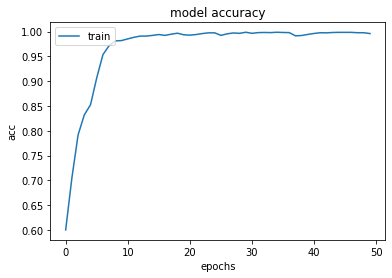

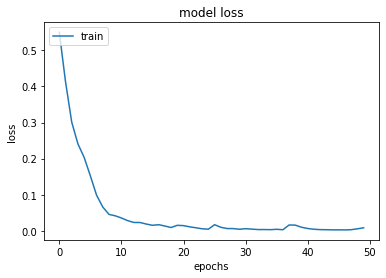

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [30]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 0.0064 - acc: 0.9976 - 1s/epoch - 11ms/step
23/23 - 0s - loss: 1.1752 - acc: 0.7070 - 171ms/epoch - 7ms/step
Train: 0.998, Test: 0.7070


## Evaluation

In [31]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
# yhat_classes = model.predict_classes(X_test, verbose=0)


predict_x=model.predict(X_test) 
yhat_classes=np.argmax(predict_x,axis=1)

print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[7.2994662e-05 9.9987340e-01 5.3648699e-05]
 [9.9999118e-01 4.1161902e-06 4.6753971e-06]
 [3.0553647e-04 9.9944466e-01 2.4981907e-04]
 ...
 [9.9999356e-01 4.1510166e-06 2.2412007e-06]
 [2.2504091e-05 9.9995923e-01 1.8210574e-05]
 [9.9999988e-01 1.2086440e-07 2.8529424e-08]]
[1 0 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 2 0 1 1 2 1 0 2
 0 1 1 0 1 0 0 0 1 1 1 0 1 2 1 0 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 2 1 1 0 1 0 1 2 1 1 2 0 1 1 1 2 1 1
 1 2 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 2 1 0 1 0 1 1 1 1 1 1 0 1 1 2 1
 2 1 1 0 1 2 1 0 0 1 2 2 0 1 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 0 0 1 1 1
 2 0 0 1 1 1 0 0 1 2 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 2 1 0 0 1
 1 1 1 1 1 0 1 1 0 0 0 1 2 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 2 0 1 1 1
 1 0 0 1 0 2 2 0 1 1 1 1 1 2 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 2 0 1 2 1
 1 2 0 1 0 1 1 1 1 2 1 0 1 0 1 2 0 1 1 1 1 1 1 0 1 2 0 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 

In [38]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[141,  71,   3],
       [ 83, 326,  17],
       [ 16,  23,  47]])

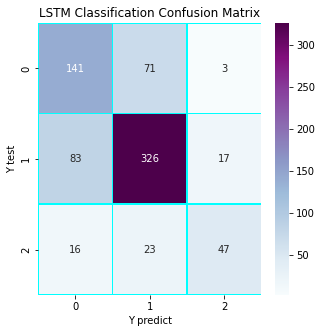

In [40]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [41]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 8ms/step - loss: 1.1636 - acc: 0.7436
score: 1.16
acc: 0.74


In [55]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision = precision_score(rounded_labels, yhat_classes, average = 'macro')
recall = recall_score(rounded_labels, yhat_classes, average = 'macro')
f1 = f1_score(rounded_labels, yhat_classes, average = 'macro')

print(precision)
print(recall)
print(f1)

0.6883943378346364
0.6558612657859301
0.6682816279812526


In [56]:
model.save('Mymodel.h5')

## Tesing New Inputs

In [32]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.9908083  0.00563567 0.0035561 ]] 0


In [33]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[3.5811632e-03 9.2142553e-04 9.9549747e-01]] 2


In [34]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[1.0786575e-09 1.0000000e+00 2.4114524e-09]] 1


In [35]:


message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])



[[9.9957806e-01 4.1401849e-04 7.9053634e-06]] 0


In [36]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[3.6697056e-06 9.9999511e-01 1.1580016e-06]] 1


In [37]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[8.7507509e-08 6.2331345e-08 9.9999988e-01]] 2
